Task-1

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define file paths for the 12-lead ECG data and labels
lead_file_paths = {
    "LEAD_I": "../Data_processing/data_aspire_PAP/LEAD_I.pt",
    "LEAD_II": "../Data_processing/data_aspire_PAP/LEAD_II.pt",
    "LEAD_III": "../Data_processing/data_aspire_PAP/LEAD_III.pt",
    "LEAD_aVR": "../Data_processing/data_aspire_PAP/LEAD_aVR.pt",
    "LEAD_aVL": "../Data_processing/data_aspire_PAP/LEAD_aVL.pt",
    "LEAD_aVF": "../Data_processing/data_aspire_PAP/LEAD_aVF.pt",
    "LEAD_V1": "../Data_processing/data_aspire_PAP/LEAD_V1.pt",
    "LEAD_V2": "../Data_processing/data_aspire_PAP/LEAD_V2.pt",
    "LEAD_V3": "../Data_processing/data_aspire_PAP/LEAD_V3.pt",
    "LEAD_V4": "../Data_processing/data_aspire_PAP/LEAD_V4.pt",
    "LEAD_V5": "../Data_processing/data_aspire_PAP/LEAD_V5.pt",
    "LEAD_V6": "../Data_processing/data_aspire_PAP/LEAD_V6.pt"
}
labels_file_path = "../Data_processing/data_aspire_PAP/labels.pt"


# Load all lead tensors and labels
ecg_lead_tensors = {lead: torch.load(path) for lead, path in lead_file_paths.items()}
labels = torch.load(labels_file_path)

# Ensure all leads have the same number of samples as the labels
sample_count = len(next(iter(ecg_lead_tensors.values())))
assert len(labels) == sample_count, "Mismatch between number of labels and samples."
for tensor in ecg_lead_tensors.values():
    assert len(tensor) == sample_count, "All leads must have the same number of samples."

# Define the dataset class
class ECGMultiLeadDatasetWithLabels(Dataset):
    def __init__(self, ecg_leads, labels):
        self.ecg_leads = ecg_leads
        self.labels = labels

    def __len__(self):
        return len(next(iter(self.ecg_leads.values())))

    def __getitem__(self, idx):
        # Return each lead sample with the correct input shape and corresponding label
        lead_data = {lead: self.ecg_leads[lead][idx].unsqueeze(0) for lead in self.ecg_leads}
        label = self.labels[idx]
        return lead_data, label

# Initialize the dataset and dataloader
dataset = ECGMultiLeadDatasetWithLabels(ecg_lead_tensors, labels)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
import torch.nn as nn

# --- Lead order for mapping (matches your MoPoE encoder order) ---
LEAD_ORDER = ["LEAD_I", "LEAD_II", "LEAD_III", "LEAD_aVR", "LEAD_aVL", "LEAD_aVF",
              "LEAD_V1", "LEAD_V2", "LEAD_V3", "LEAD_V4", "LEAD_V5", "LEAD_V6"]
LEAD_INDEX_MAP = {lead: idx for idx, lead in enumerate(LEAD_ORDER)}

class ECGLeadClassifier(nn.Module):
    def __init__(self, pretrained_mopoe, num_classes, lead_names):
        super(ECGLeadClassifier, self).__init__()
        self.lead_names = lead_names  # e.g., ["LEAD_I"], ["LEAD_I", "LEAD_II"], etc.
        self.lead_encoders = nn.ModuleList(
            [pretrained_mopoe.encoders[LEAD_INDEX_MAP[lead]] for lead in lead_names]
        )
        self.feature_dim = pretrained_mopoe.latent_dim

        for encoder in self.lead_encoders:
            for param in encoder.parameters():
                param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(len(self.lead_names) * self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, lead_data):
        lead_features = []
        for lead_name, encoder in zip(self.lead_names, self.lead_encoders):
            mu, _ = encoder(lead_data[lead_name])
            lead_features.append(mu)
        combined_features = torch.cat(lead_features, dim=1)
        logits = self.classifier(combined_features)
        return logits

In [ ]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, matthews_corrcoef
import torch.optim as optim
import torch.nn as nn

# **Set device configuration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# **Set seed for reproducibility**
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)

# ---- Existing training and evaluation functions ----

def train_classifier(model, train_loader, criterion, optimizer, epochs=10, lead_names=None):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            lead_data, labels = batch
            labels = labels.to(device)
            lead_data = {lead: lead_data[lead].to(device) for lead in lead_names}
            optimizer.zero_grad()
            outputs = model(lead_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * labels.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

def evaluate_model(model, data_loader, lead_names=None):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []
    with torch.no_grad():
        for batch in data_loader:
            lead_data, labels = batch
            labels = labels.to(device)
            lead_data = {lead: lead_data[lead].to(device) for lead in lead_names}
            logits = model(lead_data)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    auc_score = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    return accuracy, auc_score, f1, mcc


# -- Lead groups to evaluate --
single_leads = [["LEAD_I"], ["LEAD_II"], ["LEAD_III"], ["LEAD_aVR"], ["LEAD_aVL"], ["LEAD_aVF"]]
multi_lead_groups = [
    ["LEAD_I", "LEAD_II", "LEAD_III"],
    ["LEAD_aVR", "LEAD_aVL", "LEAD_aVF"],
]
all_lead_configs = single_leads + multi_lead_groups

all_results = {}

for lead_group in all_lead_configs:
    print(f'\n===== Evaluating leads: {lead_group} =====')
    reduced_lead_tensors = {lead: ecg_lead_tensors[lead] for lead in lead_group}
    dataset = ECGMultiLeadDatasetWithLabels(reduced_lead_tensors, labels)
    fold_results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_ids, test_ids) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f'FOLD {fold}')
        train_subset = Subset(dataset, train_ids)
        test_subset = Subset(dataset, test_ids)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

        # Load your pretrained MoPoE model as before
        params = {'latent_dim': 256, 'input_dim_per_lead': 5000, 'num_leads': 12}
        prior_dist = prior_expert(params['latent_dim'])
        pretrained_mopoe = LSEMVAE(
            prior_dist=prior_dist,
            latent_dim=params['latent_dim'],
            num_leads=params['num_leads'],
            input_dim_per_lead=params['input_dim_per_lead']
        )
        state_dict = torch.load("../Main/HPC/pretrain/LS_EMVAE_with_reg_12_lead.pth", map_location=device)
        new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
        pretrained_mopoe.load_state_dict(new_state_dict, strict=False)
        pretrained_mopoe.to(device)

        model = ECGLeadClassifier(pretrained_mopoe=pretrained_mopoe, num_classes=2, lead_names=lead_group).to(device)
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        train_classifier(model, train_loader, criterion, optimizer, epochs=50, lead_names=lead_group)
        accuracy, auc_score, f1, mcc = evaluate_model(model, test_loader, lead_names=lead_group)
        fold_results.append((accuracy, auc_score, f1, mcc))
        print(f'Fold {fold} Results: Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}\n')

    accuracies, aucs, f1s, mccs = zip(*fold_results)
    print(f'==> Mean Accuracy: {np.mean(accuracies):.4f}, STD: {np.std(accuracies):.4f}')
    print(f'==> Mean AUC: {np.mean(aucs):.4f}, STD: {np.std(aucs):.4f}')
    print(f'==> Mean F1: {np.mean(f1s):.4f}, STD: {np.std(f1s):.4f}')
    print(f'==> Mean MCC: {np.mean(mccs):.4f}, STD: {np.std(mccs):.4f}')
    all_results[",".join(lead_group)] = {
        "acc_mean": np.mean(accuracies), "acc_std": np.std(accuracies),
        "auc_mean": np.mean(aucs), "auc_std": np.std(aucs),
        "f1_mean": np.mean(f1s), "f1_std": np.std(f1s),
        "mcc_mean": np.mean(mccs), "mcc_std": np.std(mccs),
    }

print("\n=== All Results Summary ===")
for lead_key, res in all_results.items():
    print(f"{lead_key}: "
          f"Acc {res['acc_mean']:.4f}±{res['acc_std']:.4f} | "
          f"AUC {res['auc_mean']:.4f}±{res['auc_std']:.4f} | "
          f"F1 {res['f1_mean']:.4f}±{res['f1_std']:.4f} | "
          f"MCC {res['mcc_mean']:.4f}±{res['mcc_std']:.4f}")


Task-2

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

lead_file_paths = {
    "LEAD_I": "../Data_processing/data_aspire_PAWP/LEAD_I.pt",
    "LEAD_II": "../Data_processing/data_aspire_PAWP/LEAD_II.pt",
    "LEAD_III": "../Data_processing/data_aspire_PAWP/LEAD_III.pt",
    "LEAD_aVR": "../Data_processing/data_aspire_PAWP/LEAD_aVR.pt",
    "LEAD_aVL": "../Data_processing/data_aspire_PAWP/LEAD_aVL.pt",
    "LEAD_aVF": "../Data_processing/data_aspire_PAWP/LEAD_aVF.pt",
    "LEAD_V1": "../Data_processing/data_aspire_PAWP/LEAD_V1.pt",
    "LEAD_V2": "../Data_processing/data_aspire_PAWP/LEAD_V2.pt",
    "LEAD_V3": "../Data_processing/data_aspire_PAWP/LEAD_V3.pt",
    "LEAD_V4": "../Data_processing/data_aspire_PAWP/LEAD_V4.pt",
    "LEAD_V5": "../Data_processing/data_aspire_PAWP/LEAD_V5.pt",
    "LEAD_V6": "../Data_processing/data_aspire_PAWP/LEAD_V6.pt"
}
labels_file_path = "../Data_processing/data_aspire_PAWP/labels.pt"


# Load all lead tensors and labels
ecg_lead_tensors = {lead: torch.load(path) for lead, path in lead_file_paths.items()}
labels = torch.load(labels_file_path)

# Ensure all leads have the same number of samples as the labels
sample_count = len(next(iter(ecg_lead_tensors.values())))
assert len(labels) == sample_count, "Mismatch between number of labels and samples."
for tensor in ecg_lead_tensors.values():
    assert len(tensor) == sample_count, "All leads must have the same number of samples."

# Define the dataset class
class ECGMultiLeadDatasetWithLabels(Dataset):
    def __init__(self, ecg_leads, labels):
        self.ecg_leads = ecg_leads
        self.labels = labels

    def __len__(self):
        return len(next(iter(self.ecg_leads.values())))

    def __getitem__(self, idx):
        # Return each lead sample with the correct input shape and corresponding label
        lead_data = {lead: self.ecg_leads[lead][idx].unsqueeze(0) for lead in self.ecg_leads}
        label = self.labels[idx]
        return lead_data, label

# Initialize the dataset and dataloader
dataset = ECGMultiLeadDatasetWithLabels(ecg_lead_tensors, labels)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [ ]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, matthews_corrcoef
import torch.optim as optim
import torch.nn as nn

# **Set device configuration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# **Set seed for reproducibility**
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)

# ---- Existing training and evaluation functions ----

def train_classifier(model, train_loader, criterion, optimizer, epochs=10, lead_names=None):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            lead_data, labels = batch
            labels = labels.to(device)
            lead_data = {lead: lead_data[lead].to(device) for lead in lead_names}
            optimizer.zero_grad()
            outputs = model(lead_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * labels.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

def evaluate_model(model, data_loader, lead_names=None):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []
    with torch.no_grad():
        for batch in data_loader:
            lead_data, labels = batch
            labels = labels.to(device)
            lead_data = {lead: lead_data[lead].to(device) for lead in lead_names}
            logits = model(lead_data)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    auc_score = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    return accuracy, auc_score, f1, mcc


# -- Lead groups to evaluate --
single_leads = [["LEAD_I"], ["LEAD_II"], ["LEAD_III"], ["LEAD_aVR"], ["LEAD_aVL"], ["LEAD_aVF"]]
multi_lead_groups = [
    ["LEAD_I", "LEAD_II", "LEAD_III"],
    ["LEAD_aVR", "LEAD_aVL", "LEAD_aVF"],
]
all_lead_configs = single_leads + multi_lead_groups

all_results = {}

for lead_group in all_lead_configs:
    print(f'\n===== Evaluating leads: {lead_group} =====')
    reduced_lead_tensors = {lead: ecg_lead_tensors[lead] for lead in lead_group}
    dataset = ECGMultiLeadDatasetWithLabels(reduced_lead_tensors, labels)
    fold_results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_ids, test_ids) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f'FOLD {fold}')
        train_subset = Subset(dataset, train_ids)
        test_subset = Subset(dataset, test_ids)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

        # Load your pretrained MoPoE model as before
        params = {'latent_dim': 256, 'input_dim_per_lead': 5000, 'num_leads': 12}
        prior_dist = prior_expert(params['latent_dim'])
        pretrained_mopoe = LSEMVAE(
            prior_dist=prior_dist,
            latent_dim=params['latent_dim'],
            num_leads=params['num_leads'],
            input_dim_per_lead=params['input_dim_per_lead']
        )
        state_dict = torch.load("../Main/HPC/pretrain/LS_EMVAE_with_reg_12_lead.pth", map_location=device)
        new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
        pretrained_mopoe.load_state_dict(new_state_dict, strict=False)
        pretrained_mopoe.to(device)

        model = ECGLeadClassifier(pretrained_mopoe=pretrained_mopoe, num_classes=2, lead_names=lead_group).to(device)
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        train_classifier(model, train_loader, criterion, optimizer, epochs=50, lead_names=lead_group)
        accuracy, auc_score, f1, mcc = evaluate_model(model, test_loader, lead_names=lead_group)
        fold_results.append((accuracy, auc_score, f1, mcc))
        print(f'Fold {fold} Results: Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}\n')

    accuracies, aucs, f1s, mccs = zip(*fold_results)
    print(f'==> Mean Accuracy: {np.mean(accuracies):.4f}, STD: {np.std(accuracies):.4f}')
    print(f'==> Mean AUC: {np.mean(aucs):.4f}, STD: {np.std(aucs):.4f}')
    print(f'==> Mean F1: {np.mean(f1s):.4f}, STD: {np.std(f1s):.4f}')
    print(f'==> Mean MCC: {np.mean(mccs):.4f}, STD: {np.std(mccs):.4f}')
    all_results[",".join(lead_group)] = {
        "acc_mean": np.mean(accuracies), "acc_std": np.std(accuracies),
        "auc_mean": np.mean(aucs), "auc_std": np.std(aucs),
        "f1_mean": np.mean(f1s), "f1_std": np.std(f1s),
        "mcc_mean": np.mean(mccs), "mcc_std": np.std(mccs),
    }

print("\n=== All Results Summary ===")
for lead_key, res in all_results.items():
    print(f"{lead_key}: "
          f"Acc {res['acc_mean']:.4f}±{res['acc_std']:.4f} | "
          f"AUC {res['auc_mean']:.4f}±{res['auc_std']:.4f} | "
          f"F1 {res['f1_mean']:.4f}±{res['f1_std']:.4f} | "
          f"MCC {res['mcc_mean']:.4f}±{res['mcc_std']:.4f}")


Task-3

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
# File paths
lead_file_paths = {
    "LEAD_I": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_I.pt",
    "LEAD_II": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_II.pt",
    "LEAD_III": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_III.pt",
    "LEAD_aVR": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_aVR.pt",
    "LEAD_aVL": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_aVL.pt",
    "LEAD_aVF": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_aVF.pt",
    "LEAD_V1": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_V1.pt",
    "LEAD_V2": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_V2.pt",
    "LEAD_V3": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_V3.pt",
    "LEAD_V4": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_V4.pt",
    "LEAD_V5": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_V5.pt",
    "LEAD_V6": "D:/ukbiobank/ECG_PAWP_UKB_Final/LEAD_V6.pt"
}
labels_file_path = "D:/ukbiobank/ECG_PAWP_UKB_Final/labels.pt"

# Load all lead tensors and labels
ecg_lead_tensors = {lead: torch.load(path) for lead, path in lead_file_paths.items()}
labels = torch.load(labels_file_path)

# Ensure all leads have the same number of samples as the labels
sample_count = len(next(iter(ecg_lead_tensors.values())))
print(len(labels))
print(sample_count)
assert len(labels) == sample_count, "Mismatch between number of labels and samples."
for tensor in ecg_lead_tensors.values():
    assert len(tensor) == sample_count, "All leads must have the same number of samples."

# Define the dataset class
class ECGMultiLeadDatasetWithLabels(Dataset):
    def __init__(self, ecg_leads, labels):
        self.ecg_leads = ecg_leads
        self.labels = labels

    def __len__(self):
        return len(next(iter(self.ecg_leads.values())))

    def __getitem__(self, idx):
        # Return each lead sample with the correct input shape and corresponding label
        lead_data = {lead: self.ecg_leads[lead][idx].unsqueeze(0) for lead in self.ecg_leads}
        label = self.labels[idx]
        return lead_data, label

# Initialize the dataset and dataloader
dataset = ECGMultiLeadDatasetWithLabels(ecg_lead_tensors, labels)

In [ ]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, matthews_corrcoef
import torch.optim as optim
import torch.nn as nn

# **Set device configuration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# **Set seed for reproducibility**
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)

# ---- Existing training and evaluation functions ----

def train_classifier(model, train_loader, criterion, optimizer, epochs=10, lead_names=None):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            lead_data, labels = batch
            labels = labels.to(device)
            lead_data = {lead: lead_data[lead].to(device) for lead in lead_names}
            optimizer.zero_grad()
            outputs = model(lead_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * labels.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

def evaluate_model(model, data_loader, lead_names=None):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []
    with torch.no_grad():
        for batch in data_loader:
            lead_data, labels = batch
            labels = labels.to(device)
            lead_data = {lead: lead_data[lead].to(device) for lead in lead_names}
            logits = model(lead_data)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    auc_score = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    return accuracy, auc_score, f1, mcc


# -- Lead groups to evaluate --
single_leads = [["LEAD_I"], ["LEAD_II"], ["LEAD_III"], ["LEAD_aVR"], ["LEAD_aVL"], ["LEAD_aVF"]]
multi_lead_groups = [
    ["LEAD_I", "LEAD_II", "LEAD_III"],
    ["LEAD_aVR", "LEAD_aVL", "LEAD_aVF"],
]
all_lead_configs = single_leads + multi_lead_groups

all_results = {}

for lead_group in all_lead_configs:
    print(f'\n===== Evaluating leads: {lead_group} =====')
    reduced_lead_tensors = {lead: ecg_lead_tensors[lead] for lead in lead_group}
    dataset = ECGMultiLeadDatasetWithLabels(reduced_lead_tensors, labels)
    fold_results = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_ids, test_ids) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f'FOLD {fold}')
        train_subset = Subset(dataset, train_ids)
        test_subset = Subset(dataset, test_ids)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

        # Load your pretrained MoPoE model as before
        params = {'latent_dim': 256, 'input_dim_per_lead': 5000, 'num_leads': 12}
        prior_dist = prior_expert(params['latent_dim'])
        pretrained_mopoe = LSEMVAE(
            prior_dist=prior_dist,
            latent_dim=params['latent_dim'],
            num_leads=params['num_leads'],
            input_dim_per_lead=params['input_dim_per_lead']
        )
        state_dict = torch.load("../Main/HPC/pretrain/LS_EMVAE_with_reg_12_lead.pth", map_location=device)
        new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
        pretrained_mopoe.load_state_dict(new_state_dict, strict=False)
        pretrained_mopoe.to(device)

        model = ECGLeadClassifier(pretrained_mopoe=pretrained_mopoe, num_classes=2, lead_names=lead_group).to(device)
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        criterion = torch.nn.CrossEntropyLoss()

        train_classifier(model, train_loader, criterion, optimizer, epochs=50, lead_names=lead_group)
        accuracy, auc_score, f1, mcc = evaluate_model(model, test_loader, lead_names=lead_group)
        fold_results.append((accuracy, auc_score, f1, mcc))
        print(f'Fold {fold} Results: Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}\n')

    accuracies, aucs, f1s, mccs = zip(*fold_results)
    print(f'==> Mean Accuracy: {np.mean(accuracies):.4f}, STD: {np.std(accuracies):.4f}')
    print(f'==> Mean AUC: {np.mean(aucs):.4f}, STD: {np.std(aucs):.4f}')
    print(f'==> Mean F1: {np.mean(f1s):.4f}, STD: {np.std(f1s):.4f}')
    print(f'==> Mean MCC: {np.mean(mccs):.4f}, STD: {np.std(mccs):.4f}')
    all_results[",".join(lead_group)] = {
        "acc_mean": np.mean(accuracies), "acc_std": np.std(accuracies),
        "auc_mean": np.mean(aucs), "auc_std": np.std(aucs),
        "f1_mean": np.mean(f1s), "f1_std": np.std(f1s),
        "mcc_mean": np.mean(mccs), "mcc_std": np.std(mccs),
    }

print("\n=== All Results Summary ===")
for lead_key, res in all_results.items():
    print(f"{lead_key}: "
          f"Acc {res['acc_mean']:.4f}±{res['acc_std']:.4f} | "
          f"AUC {res['auc_mean']:.4f}±{res['auc_std']:.4f} | "
          f"F1 {res['f1_mean']:.4f}±{res['f1_std']:.4f} | "
          f"MCC {res['mcc_mean']:.4f}±{res['mcc_std']:.4f}")


Visualization

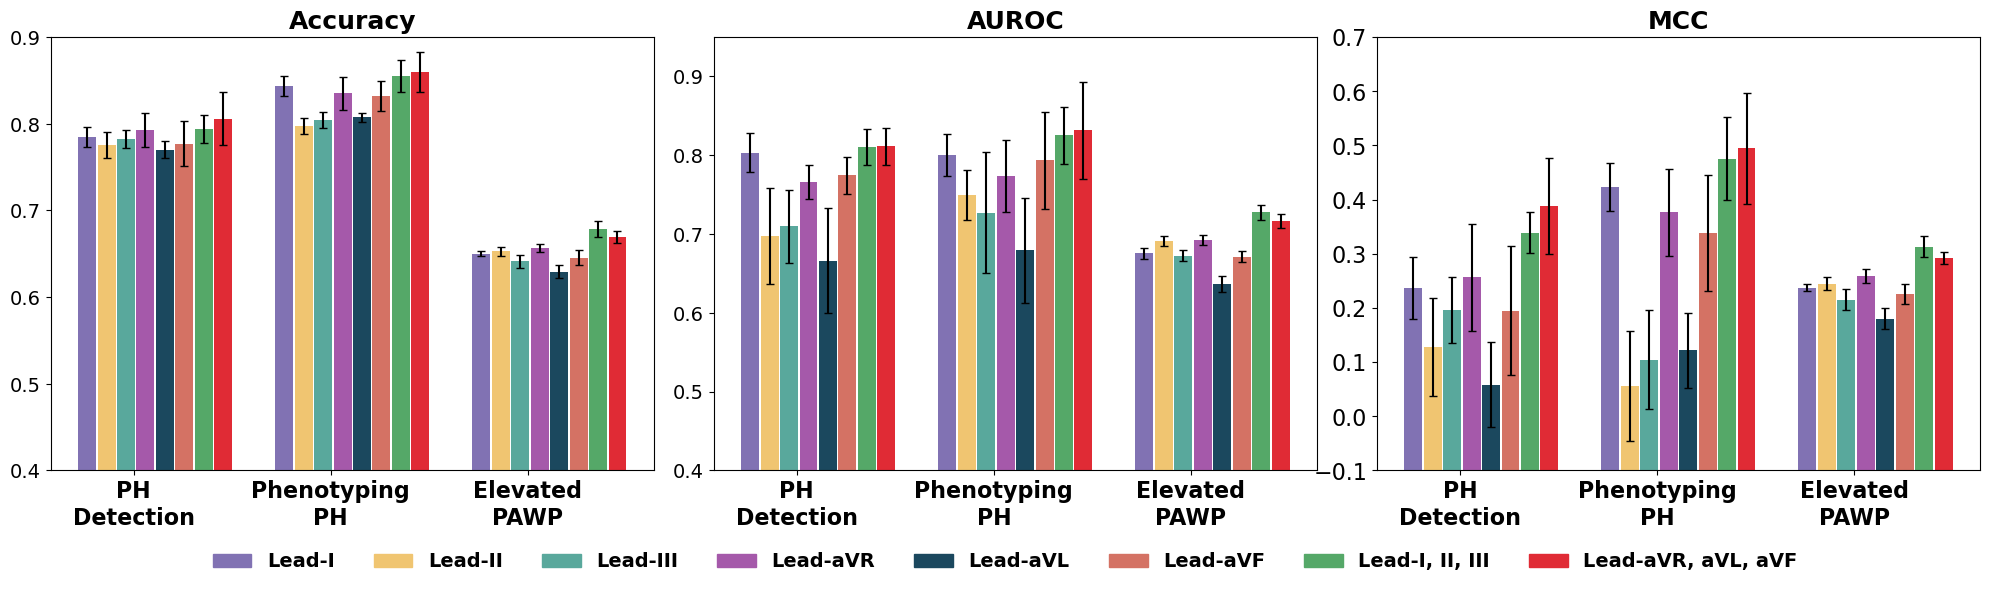

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# === DATA ===

# Accuracy
task1_means = {
    "Task-1": [0.7848, 0.7758, 0.7825, 0.7926, 0.7702, 0.7769, 0.7937, 0.8060],
    "Task-2": [0.8437, 0.7974, 0.8046, 0.8351, 0.8075, 0.8321, 0.8553, 0.8596],
    "Task-3": [0.6502, 0.6526, 0.6414, 0.6564, 0.6293, 0.6453, 0.6782, 0.6692]
}
task1_errs = {
    "Task-1": [0.0113, 0.0152, 0.0100, 0.0198, 0.0102, 0.0257, 0.0159, 0.0302],
    "Task-2": [0.0114, 0.0096, 0.0090, 0.0188, 0.0053, 0.0170, 0.0182, 0.0235],
    "Task-3": [0.0032, 0.0053, 0.0076, 0.0049, 0.0072, 0.0086, 0.0092, 0.0068]
}

# AUROC
task2_means = {
    "Task-1": [0.8029, 0.6975, 0.7096, 0.7661, 0.6663, 0.7745, 0.8103, 0.8111],
    "Task-2": [0.8003, 0.7494, 0.7273, 0.7737, 0.6791, 0.7938, 0.8252, 0.8317],
    "Task-3": [0.6754, 0.6909, 0.6722, 0.6922, 0.6360, 0.6711, 0.7278, 0.7162]
}
task2_errs = {
    "Task-1": [0.0248, 0.0610, 0.0465, 0.0213, 0.0668, 0.0231, 0.0231, 0.0232],
    "Task-2": [0.0266, 0.0321, 0.0766, 0.0453, 0.0671, 0.0615, 0.0359, 0.0614],
    "Task-3": [0.0068, 0.0067, 0.0069, 0.0067, 0.0102, 0.0068, 0.0096, 0.0090]
}

# MCC
task3_means = {
    "Task-1": [0.2365, 0.1275, 0.1966, 0.2566, 0.0581, 0.1946, 0.3391, 0.3884],
    "Task-2": [0.4233, 0.0557, 0.1045, 0.3766, 0.1219, 0.3377, 0.4756, 0.4949],
    "Task-3": [0.2376, 0.2447, 0.2151, 0.2590, 0.1802, 0.2259, 0.3131, 0.2918]
}
task3_errs = {
    "Task-1": [0.0568, 0.0905, 0.0606, 0.0988, 0.0787, 0.1194, 0.0381, 0.0885],
    "Task-2": [0.0441, 0.1020, 0.0908, 0.0804, 0.0690, 0.1072, 0.0769, 0.1025],
    "Task-3": [0.0071, 0.0125, 0.0191, 0.0131, 0.0196, 0.0184, 0.0198, 0.0115]
}

# Colors
group_colors = [
    "#8172B3", "#f0c571", "#59a89c", "#a559aa",
    "#1b485e", "#d47264", "#55A868", "#e02b35"
]
lead_labels = [
    "Lead-I", "Lead-II", "Lead-III", "Lead-aVR", "Lead-aVL",
    "Lead-aVF", "Lead-I, II, III", "Lead-aVR, aVL, aVF"
]

# === PLOTTING FUNCTIONS ===

def plot_grouped_bars_vertical(ax, means_dict, errs_dict, title, ylim, show_y_labels=False):
    x_positions = [0.5, 1.05, 1.6]

    offsets = np.linspace(-0.13, 0.25, 8)
    bar_width = 0.05

    for idx, task in enumerate(["Task-1", "Task-2", "Task-3"]):
        base_x = x_positions[idx]
        for i in range(8):
            ax.bar(
                base_x + offsets[i],
                means_dict[task][i],
                yerr=errs_dict[task][i],
                width=bar_width,
                capsize=3,
                color=group_colors[i]
            )

    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_ylim(*ylim)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(labelleft=show_y_labels)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(["PH\nDetection", "Phenotyping\nPH", "Elevated\nPAWP"], fontsize=16, fontweight='bold')

def plot_grouped_bars_vertical_mcc(ax, means_dict, errs_dict, title, ylim, show_y_labels=False):
    x_positions = [0.5, 1.05, 1.6]

    offsets = np.linspace(-0.13, 0.25, 8)
    bar_width = 0.05
    baseline = -0.1

    for idx, task in enumerate(["Task-1", "Task-2", "Task-3"]):
        base_x = x_positions[idx]
        for i in range(8):
            ax.bar(
                base_x + offsets[i],
                means_dict[task][i] - baseline,
                yerr=errs_dict[task][i],
                bottom=baseline,
                width=bar_width,
                capsize=3,
                color=group_colors[i]
            )

    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_ylim(*ylim)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(labelleft=show_y_labels)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(["PH\nDetection", "Phenotyping\nPH", "Elevated\nPAWP"], fontsize=16, fontweight='bold')

# === CREATE FIGURE ===

fig, axes = plt.subplots(1, 3, figsize=(20, 5.5))
plt.subplots_adjust(wspace=0.3, bottom=0.25)

plot_grouped_bars_vertical(axes[0], task1_means, task1_errs, "Accuracy", (0.4, 0.9), show_y_labels=True)
plot_grouped_bars_vertical(axes[1], task2_means, task2_errs, "AUROC", (0.4, 0.95), show_y_labels=True)
plot_grouped_bars_vertical_mcc(axes[2], task3_means, task3_errs, "MCC", (-0.1, 0.7), show_y_labels=True)

# Legend
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(group_colors, lead_labels)]
fig.legend(
    handles=legend_handles,
    loc='lower left',
    bbox_to_anchor=(0.1, -0.08),
    ncol=8,
    frameon=False, prop={'weight': 'bold', 'size': 14}
)

plt.tight_layout()
plt.show()
fig.savefig("Grouped_ECG_VerticalBarPlots.pdf", format="pdf", dpi=600, bbox_inches='tight')